# Joe Biden 

## Sentiment Analysis via NewsAPI

In [1]:
# Initial imports
import os
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import nltk as nltk
from newsapi.newsapi_client import NewsApiClient
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import matplotlib.pyplot as plt
import dataframe_image as dfi

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

# Set News API Key
newsapi = NewsApiClient(api_key=os.environ["NEWS_API_KEY"])

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create Alpaca Trade API client
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [3]:
# Create a newsapi client
api_key = os.getenv("NEWS_API_KEY")
newsapi = NewsApiClient(api_key=api_key)

In [4]:
# Fetch news articles
biden_news = newsapi.get_everything(
    q="joe biden",
    language="en"
)

# Show the total number of news
biden_news["totalResults"]

31474

In [5]:
# Function to create a dataframe for news articles
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError as ae:
            pass

    return pd.DataFrame(articles)

In [6]:
# Create a DataFrame with Trump news
biden_df = create_df(biden_news["articles"], "en") 
biden_df.head()

,title,description,text,date,language
0,Joe Biden Is Still Right. Putin Has to Go.,Russian atrocities in Ukraine require the West...,But this requires a clear articulation of West...,2022-04-05,en
1,NASA would get $26 billion in new budget request,President Joe Biden released his administratio...,"Money for Artemis, space stations, and more\r\...",2022-03-28,en
2,Biden: Russia 'exploring' US cyber-attacks,"President Joe Biden says US companies should ""...",By James ClaytonNorth America technology repor...,2022-03-22,en
3,Biden Finally Cracks Down on Untraceable 'Ghos...,"In an effort to reduce gun violence, President...","In an effort to reduce gun violence, President...",2022-04-11,en
4,Biden says 'Americans are back to work',President Joe Biden on Friday touted the March...,(CNN)President Joe Biden on Friday touted the ...,2022-04-01,en


In [7]:
# Create the sentiment scores DataFrame
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

### Sentiment Analysis

In [8]:
# Create function for sentiment score dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# ETH - Get sentiment for the text and the title
for index, row in biden_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

In [9]:
# Attaching sentiment columns to the Ethereum news dataframe
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
biden_df = biden_df.join(title_sentiment_df).join(text_sentiment_df)

In [10]:
# Describe Trump sentiment 
biden_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.00000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.117505,0.045250,0.83445,0.120350,-0.25000,-0.136975,0.054150,0.856850,0.089000,-0.150000
std,0.342673,0.076094,0.20697,0.193141,0.71635,0.493930,0.073189,0.114219,0.088386,0.875094
min,-0.913600,0.000000,0.15700,0.000000,-1.00000,-0.897900,0.000000,0.644000,0.000000,-1.000000
25%,-0.301550,0.000000,0.75175,0.000000,-1.00000,-0.608775,0.000000,0.755250,0.000000,-1.000000
50%,0.000000,0.000000,0.83300,0.000000,0.00000,-0.012900,0.000000,0.875000,0.077500,0.000000
75%,0.000000,0.094500,1.00000,0.214750,0.00000,0.162025,0.083500,0.946750,0.140250,1.000000
max,0.493900,0.224000,1.00000,0.754000,1.00000,0.735100,0.223000,1.000000,0.291000,1.000000


<AxesSubplot:title={'center':'Joe Biden News Title and Text Sentiment Comparisson'}>

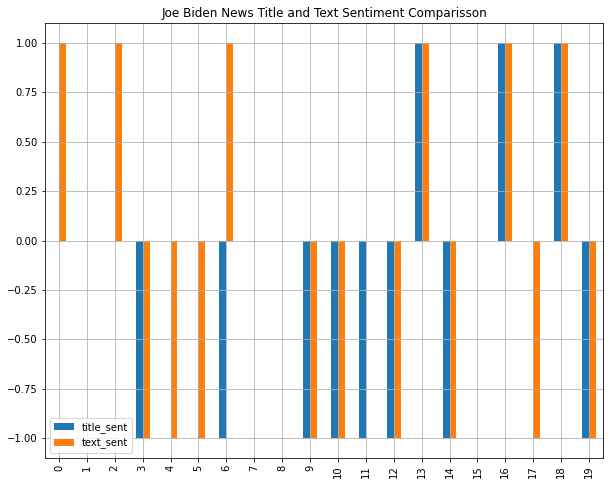

In [11]:
# Describe news sentiment
biden_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="Joe Biden News Title and Text Sentiment Comparisson",
    figsize=(10, 8),
    grid=True,
)

In [12]:
# Describe Trump dataframe 
biden_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.00000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.117505,0.045250,0.83445,0.120350,-0.25000,-0.136975,0.054150,0.856850,0.089000,-0.150000
std,0.342673,0.076094,0.20697,0.193141,0.71635,0.493930,0.073189,0.114219,0.088386,0.875094
min,-0.913600,0.000000,0.15700,0.000000,-1.00000,-0.897900,0.000000,0.644000,0.000000,-1.000000
25%,-0.301550,0.000000,0.75175,0.000000,-1.00000,-0.608775,0.000000,0.755250,0.000000,-1.000000
50%,0.000000,0.000000,0.83300,0.000000,0.00000,-0.012900,0.000000,0.875000,0.077500,0.000000
75%,0.000000,0.094500,1.00000,0.214750,0.00000,0.162025,0.083500,0.946750,0.140250,1.000000
max,0.493900,0.224000,1.00000,0.754000,1.00000,0.735100,0.223000,1.000000,0.291000,1.000000


## Tokenizer

In [13]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import reuters, stopwords
from string import punctuation
import re

In [14]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()
article = biden_df
print(article)

                                                title  \
0          Joe Biden Is Still Right. Putin Has to Go.   
1    NASA would get $26 billion in new budget request   
2          Biden: Russia 'exploring' US cyber-attacks   
3   Biden Finally Cracks Down on Untraceable 'Ghos...   
4             Biden says 'Americans are back to work'   
5    Biden: President looks into additional sanctions   
6      Western leaders unite a month into Russian war   
7   Bidens to host White House wedding reception f...   
8   Airline CEOs urge Biden to end mask mandate, t...   
9   Biden uses call with Xi to lay out consequence...   
10  Growing ghost gun problem adds to America's vi...   
11  Opinion: Why the US should investigate Russian...   
12  Republicans Once Silent on Russia Ratchet Up A...   
13  Obama returning to White House this week for A...   
14  Joe Biden accuses Vladimir Putin of committing...   
15    In pictures: Biden's high-stakes trip to Europe   
16  Diplomacy: US national secu

In [15]:
# Instantiate the lemmatizer (Bitcoin)
lemmatizer = WordNetLemmatizer()
article = biden_df
print(article)

                                                title  \
0          Joe Biden Is Still Right. Putin Has to Go.   
1    NASA would get $26 billion in new budget request   
2          Biden: Russia 'exploring' US cyber-attacks   
3   Biden Finally Cracks Down on Untraceable 'Ghos...   
4             Biden says 'Americans are back to work'   
5    Biden: President looks into additional sanctions   
6      Western leaders unite a month into Russian war   
7   Bidens to host White House wedding reception f...   
8   Airline CEOs urge Biden to end mask mandate, t...   
9   Biden uses call with Xi to lay out consequence...   
10  Growing ghost gun problem adds to America's vi...   
11  Opinion: Why the US should investigate Russian...   
12  Republicans Once Silent on Russia Ratchet Up A...   
13  Obama returning to White House this week for A...   
14  Joe Biden accuses Vladimir Putin of committing...   
15    In pictures: Biden's high-stakes trip to Europe   
16  Diplomacy: US national secu

In [16]:
# Create a list of stopwords
sw = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
sw_addons = { "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", 
              "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", 
              "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", 
              "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", 
              "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", 
              "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", 
              "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", 
              "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", 
              "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", 
              "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", 
              "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", 
              "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", 
              "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", 
              "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", 
              "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", 
              "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", 
              "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hr", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", 
              "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", 
              "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", 
              "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", 
              "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", 
              "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", 
              "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", 
              "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", 
              "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", 
              "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", 
              "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", 
              "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", 
              "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", 
              "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", 
              "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", 
              "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", 
              "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", 
              "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", 
              "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", 
              "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", 
              "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", 
              "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", 
              "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", 
              "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", 
              "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", 
              "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", 
              "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", 
              "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", 
              "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", 
              "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"}
stop = set(list(sw)+list(sw_addons))

In [17]:
# Define function
def tokenizer(text):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', article)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw]
    return tokens

In [18]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    ## Define and apply the regex parameters
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    
    # Create a tokenized list of the words
    words = word_tokenize(text)
    
    # Convert the words to lowercase
    words = list(filter(lambda w: w.lower(), words))
    
    # Remove the punctuation from text
    words = list(filter(lambda t: t not in punctuation, words))
    
    # Remove the stop words
    words = list(filter(lambda t: t.lower() not in stop, words))
    
    # Lemmatize words into root words
    tokens = [lemmatizer.lemmatize(word) for word in words]

    return tokens

In [19]:
# Create a new tokens column for Bitcoin
biden_df["tokens"] = biden_df.text.apply(tokenizer)
biden_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,Joe Biden Is Still Right. Putin Has to Go.,Russian atrocities in Ukraine require the West...,But this requires a clear articulation of West...,2022-04-05,en,0.0000,0.0,1.000,0.000,0,0.3813,0.223,0.644,0.133,1,"[requires, clear, articulation, Western, aim, ..."
1,NASA would get $26 billion in new budget request,President Joe Biden released his administratio...,"Money for Artemis, space stations, and more\r\...",2022-03-28,en,0.0000,0.0,1.000,0.000,0,0.0000,0.000,1.000,0.000,0,"[Money, Artemis, space, station, Photo, Loren,..."
2,Biden: Russia 'exploring' US cyber-attacks,"President Joe Biden says US companies should ""...",By James ClaytonNorth America technology repor...,2022-03-22,en,0.0000,0.0,1.000,0.000,0,0.1027,0.133,0.773,0.094,1,"[James, ClaytonNorth, America, technology, rep..."
3,Biden Finally Cracks Down on Untraceable 'Ghos...,"In an effort to reduce gun violence, President...","In an effort to reduce gun violence, President...",2022-04-11,en,-0.3182,0.0,0.753,0.247,-1,-0.8979,0.000,0.709,0.291,-1,"[effort, reduce, gun, violence, President, Joe..."
4,Biden says 'Americans are back to work',President Joe Biden on Friday touted the March...,(CNN)President Joe Biden on Friday touted the ...,2022-04-01,en,0.0000,0.0,1.000,0.000,0,-0.6369,0.000,0.838,0.162,-1,"[CNN, President, Joe, Biden, Friday, touted, M..."


In [20]:
# Create new tokens column 
biden_df["tokens"] = biden_df.text.apply(tokenizer)
biden_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,Joe Biden Is Still Right. Putin Has to Go.,Russian atrocities in Ukraine require the West...,But this requires a clear articulation of West...,2022-04-05,en,0.0000,0.0,1.000,0.000,0,0.3813,0.223,0.644,0.133,1,"[requires, clear, articulation, Western, aim, ..."
1,NASA would get $26 billion in new budget request,President Joe Biden released his administratio...,"Money for Artemis, space stations, and more\r\...",2022-03-28,en,0.0000,0.0,1.000,0.000,0,0.0000,0.000,1.000,0.000,0,"[Money, Artemis, space, station, Photo, Loren,..."
2,Biden: Russia 'exploring' US cyber-attacks,"President Joe Biden says US companies should ""...",By James ClaytonNorth America technology repor...,2022-03-22,en,0.0000,0.0,1.000,0.000,0,0.1027,0.133,0.773,0.094,1,"[James, ClaytonNorth, America, technology, rep..."
3,Biden Finally Cracks Down on Untraceable 'Ghos...,"In an effort to reduce gun violence, President...","In an effort to reduce gun violence, President...",2022-04-11,en,-0.3182,0.0,0.753,0.247,-1,-0.8979,0.000,0.709,0.291,-1,"[effort, reduce, gun, violence, President, Joe..."
4,Biden says 'Americans are back to work',President Joe Biden on Friday touted the March...,(CNN)President Joe Biden on Friday touted the ...,2022-04-01,en,0.0000,0.0,1.000,0.000,0,-0.6369,0.000,0.838,0.162,-1,"[CNN, President, Joe, Biden, Friday, touted, M..."


# NGrams and Frequency Analysis

In [21]:
from collections import Counter
from nltk import ngrams

In [22]:
# Generate the N-grams where N=2
N = 2
grams = ngrams(tokenizer(biden_df.text.str.cat()), N)
Counter(grams).most_common(20)

[(('Joe', 'Biden'), 16),
 (('President', 'Joe'), 15),
 (('char', 'CNN'), 5),
 (('CNN', 'President'), 4),
 (('White', 'House'), 4),
 (('Biden', 'Monday'), 2),
 (('char', 'President'), 2),
 (('Biden', 'first'), 2),
 (('first', 'lady'), 2),
 (('Chinese', 'counterpart'), 2),
 (('President', 'Barack'), 2),
 (('Barack', 'Obama'), 2),
 (('Biden', 'delivers'), 2),
 (('delivers', 'speech'), 2),
 (('speech', 'Royal'), 2),
 (('March', '26'), 2),
 (('requires', 'clear'), 1),
 (('clear', 'articulation'), 1),
 (('articulation', 'Western'), 1),
 (('Western', 'aim'), 1)]

In [23]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [24]:
# Use token_count to get the top 10 words for Trump
obama_tokens = tokenizer(biden_df.text.str.cat())
token_count(obama_tokens, N = 10)

[('char', 20),
 ('Biden', 20),
 ('President', 19),
 ('Joe', 17),
 ('CNN', 7),
 ('House', 5),
 ('Ukraine', 4),
 ('Russia', 4),
 ('March', 4),
 ('White', 4)]

### Word Clouds

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

Text(0.5, 1.0, 'Joe Biden Word Cloud')

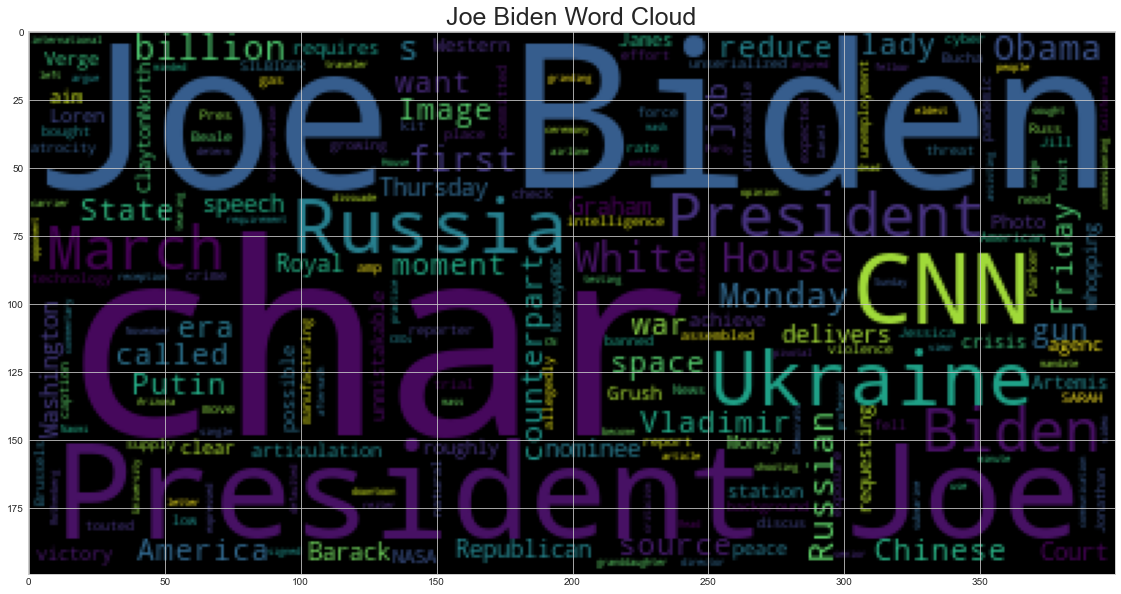

In [26]:
# Generate the Bitcoin word cloud
word_cloud = WordCloud().generate(' '.join(obama_tokens))
plt.imshow(word_cloud)
plt.title("Joe Biden Word Cloud", fontdict={'fontsize':25})

## Named Entity Recognition

In [27]:
import spacy
from spacy import displacy

In [28]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# NER

In [29]:
# Concatenate all of the Bitcoin text together
biden_NER = biden_df["text"].str.cat()

In [30]:
# Run the NER processor on all of the text
doc = nlp(biden_NER)

# Add a title to the document
doc.user_data["title"]="Joe Biden NER"

In [31]:
# Render the visualization
displacy.render(doc, style='ent')

In [32]:
# List all Entities
for i in doc.ents:
    print(i.text, i.label_)

Western NORP
Ukraine GPE
Russia GPE
Artemis ORG
Loren Grush PERSON
Verge ORG
Joe Biden PERSON
$26 billion MONEY
NASA ORG
2023 DATE
roughly $2 billion MONEY
James ClaytonNorth America PERSON
SARAH SILBIGER ORG
Joe Biden PERSON
Monday DATE
Russian NORP
US GPE
Russ PERSON
Joe Biden PERSON
Joe Biden PERSON
Friday DATE
March DATE
US GPE
431,000 CARDINAL
March DATE
American NORP
3.6% PERCENT
Joe Biden PERSON
Monday DATE
Russian NORP
Bucha GPE
Ukraine GPE
Russian NORP
Vladimir Putin PERSON
Jessica Parker PERSON
Brussels & ORG
Jonathan Beale PERSON
NorwayBBC News ORG
Biden PERSON
EU ORG
Russia GPE
US Pres ORG
Joe Biden PERSON
first ORDINAL
Jill Biden PERSON
the White House FAC
this November DATE
Naomi Biden PERSON
first ORDINAL
10 CARDINAL
Joe Biden PERSON
Joe Biden PERSON
110-minute TIME
Friday DATE
Chinese NORP
Russia GPE
Ukraine GPE
Sacramento GPE
California GPE
six CARDINAL
at least 12 CARDINAL
Joe Biden PERSON
Sunday DATE
Rothenberg PERSON
Arizona State University ORG
New America LOC
CNN 